## Implementation of PPO

Now, let's implement PPO. Since two algorithms are very similar, we can use the same codes from the previous notebook in many parts. Below, I copied the same codes from this notebook (although there might be small differences such as variable names). To be consistent, let's use the same environment 'PoleCartPole-v0' in this notebook too.

In [ ]:
# Import packages
import sys
import os

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

import tqdm

import torch
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn

from IPython.display import clear_output
from IPython import display

%matplotlib inline

# check and use GPU if available if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 6.0 MB/s eta 0:00:00


In [ ]:
# CODE from another notebook
class NeuralNet(torch.nn.Module):
    def __init__(self, input_size, output_size, activation, layers=[32,32,16]):
        super().__init__()

        # Define layers with ReLU activation
        self.linear1 = torch.nn.Linear(input_size, layers[0])
        self.activation1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(layers[0], layers[1])
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(layers[1], layers[2])
        self.activation3 = torch.nn.ReLU()

        self.output_layer = torch.nn.Linear(layers[2], output_size)
        self.output_activation = activation

        # Initialization using Xavier normal (a popular technique for initializing weights in NNs)
        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.xavier_normal_(self.linear2.weight)
        torch.nn.init.xavier_normal_(self.linear3.weight)
        torch.nn.init.xavier_normal_(self.output_layer.weight)

    def forward(self, inputs):
        # Forward pass through the layers
        x = self.activation1(self.linear1(inputs))
        x = self.activation2(self.linear2(x))
        x = self.activation3(self.linear3(x))
        x = self.output_activation(self.output_layer(x))
        return x


def generate_single_episode(env, policy_net):
    """
    Generates an episode by executing the current policy in the given env
    """
    states = []
    actions = []
    rewards = []
    log_probs = []
    max_t = 1000 # max horizon within one episode
    state, _ = env.reset()

    for t in range(max_t):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = policy_net.forward(Variable(state)) # get each action choice probability with the current policy network
        action = np.random.choice(env.action_space.n, p=np.squeeze(probs.detach().numpy())) # probablistic
        # action = np.argmax(probs.detach().numpy()) # greedy

        # compute the log_prob to use this in parameter update
        log_prob = torch.log(probs.squeeze(0)[action])

        # append values
        states.append(state)
        actions.append(action)
        log_probs.append(log_prob)

        # take a selected action
        state, reward, terminated, truncated, _ = env.step(action)
        rewards.append(reward)

        if terminated | truncated:
            break

    return states, actions, rewards, log_probs


def evaluate_policy(env, policy_net):
    """
    Compute accumulative trajectory reward
    """
    states, actions, rewards, log_probs = generate_single_episode(env, policy_net)
    return np.sum(rewards)


We use NeuralNet class to define policy and value networks. We use generate_single_episode function to generate training data by following the current policy. evaluate_policy function helps us to evaluate the performance of the current policy. There implementations are the same as REINFOREMENT with baseline.

Now, to implement PPO, we modify the implementation of train function. We will implement the for loop for epochs as well as the clipped objective as below.

In [ ]:
def train_PPO(env, policy_net, policy_optimizer, value_net, value_optimizer, num_epochs, clip_val=0.2, gamma=0.99):
    """
    Trains the policy network on a single episode using REINFORCE with baseline
    """

    # Generate an episode with the current policy network
    states, actions, rewards, log_probs = generate_single_episode(env, policy_net)
    T = len(states)

    # Create tensors
    states = np.vstack(states).astype(float)
    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device).view(-1,1)
    rewards = torch.FloatTensor(rewards).to(device).view(-1,1)
    log_probs = torch.FloatTensor(log_probs).to(device).view(-1,1)

    # Compute total discounted return at each time step
    Gs = []
    G = 0
    for t in range(T-1,-1,-1): # iterate in backward order to make the computation easier
        G = rewards[t] + gamma*G
        Gs.insert(0,G)
    Gs = torch.tensor(Gs).view(-1,1)

    # Compute the advantage
    state_vals = value_net(states).to(device)
    with torch.no_grad():
        A_k = Gs - state_vals

    for _ in range(num_epochs):
        V = value_net(states).to(device)

        # Calculate probability of each action under the updated policy
        probs = policy_net.forward(states).to(device)

        # compute the log_prob to use it in parameter update
        curr_log_probs = torch.log(torch.gather(probs, 1, actions)) # Use torch.gather(A,1,B) to select columns from A based on indices in B

        # Calculate ratios r(theta)
        ratios = torch.exp(curr_log_probs - log_probs)

        # Calculate two surrogate loss terms in cliped loss
        surr1 = ratios * A_k
        surr2 = torch.clamp(ratios, 1-clip_val, 1+clip_val) * A_k

        # Calculate clipped loss value
        actor_loss = (-torch.min(surr1, surr2)).mean() # Need negative sign to run Gradient Ascent

        # Update policy network
        policy_optimizer.zero_grad()
        actor_loss.backward(retain_graph=True)
        policy_optimizer.step()

        # Update value net
        critic_loss = nn.MSELoss()(V, Gs)
        value_optimizer.zero_grad()
        critic_loss.backward()
        value_optimizer.step()

    return policy_net, value_net



Okay, now we are ready to run PPO. Let's try running this algorithm.

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Episode: 0
The avg. test reward for episode 0 is 15.45 with std of 6.359834903517543.
Episode: 50
The avg. test reward for episode 50 is 12.55 with std of 2.801338965566288.
Episode: 100
The avg. test reward for episode 100 is 23.4 with std of 6.575712889109439.
Episode: 150
The avg. test reward for episode 150 is 24.85 with std of 6.505958807124435.
Episode: 200
The avg. test reward for episode 200 is 62.95 with std of 24.237316270577484.
Episode: 250
The avg. test reward for episode 250 is 34.55 with std of 6.152032184571208.
Episode: 300
The avg. test reward for episode 300 is 32.05 with std of 5.6786882288077765.
Episode: 350
The avg. test reward for episode 350 is 46.1 with std of 11.130588483993108.
Episode: 400
The avg. test reward for episode 400 is 60.5 with std of 31.015318795717707.
Episode: 450
The avg. test reward for episode 450 is 49.9 with std of 11.886547017532047.
Episode: 500
The avg. test reward for episode 500 is 44.25 with std of 12.036922364126138.
Episode: 550
T

 20%|██        | 1/5 [01:09<04:36, 69.10s/it]

Episode: 0
The avg. test reward for episode 0 is 15.85 with std of 5.002749244165652.
Episode: 50
The avg. test reward for episode 50 is 9.4 with std of 0.8602325267042626.
Episode: 100
The avg. test reward for episode 100 is 9.6 with std of 0.8602325267042626.
Episode: 150
The avg. test reward for episode 150 is 9.25 with std of 0.7664854858377946.
Episode: 200
The avg. test reward for episode 200 is 9.25 with std of 0.9420721840708386.
Episode: 250
The avg. test reward for episode 250 is 9.5 with std of 0.5.
Episode: 300
The avg. test reward for episode 300 is 9.15 with std of 0.7921489758877431.
Episode: 350
The avg. test reward for episode 350 is 9.35 with std of 0.7262919523166975.
Episode: 400
The avg. test reward for episode 400 is 9.15 with std of 0.7262919523166976.
Episode: 450
The avg. test reward for episode 450 is 9.15 with std of 0.7262919523166976.
Episode: 500
The avg. test reward for episode 500 is 9.25 with std of 0.698212002188447.
Episode: 550
The avg. test reward f

 40%|████      | 2/5 [01:53<02:43, 54.42s/it]

Episode: 0
The avg. test reward for episode 0 is 21.15 with std of 9.916022388034428.
Episode: 50
The avg. test reward for episode 50 is 41.35 with std of 20.950596650215.
Episode: 100
The avg. test reward for episode 100 is 58.65 with std of 24.79168207282434.
Episode: 150
The avg. test reward for episode 150 is 95.3 with std of 38.70155035654256.
Episode: 200
The avg. test reward for episode 200 is 436.15 with std of 84.30200175559298.
Episode: 250
The avg. test reward for episode 250 is 486.2 with std of 26.97517377145141.
Episode: 300
The avg. test reward for episode 300 is 461.75 with std of 51.630296338487156.
Episode: 350
The avg. test reward for episode 350 is 289.4 with std of 45.21880139941792.
Episode: 400
The avg. test reward for episode 400 is 494.55 with std of 15.71456330923644.
Episode: 450
The avg. test reward for episode 450 is 362.65 with std of 130.95429546219552.
Episode: 500
The avg. test reward for episode 500 is 474.4 with std of 51.67630017716051.
Episode: 550


 60%|██████    | 3/5 [06:13<04:56, 148.31s/it]

Episode: 0
The avg. test reward for episode 0 is 19.25 with std of 6.832825184358224.
Episode: 50
The avg. test reward for episode 50 is 26.85 with std of 7.281998352100884.
Episode: 100
The avg. test reward for episode 100 is 83.8 with std of 23.22843085531177.
Episode: 150
The avg. test reward for episode 150 is 49.85 with std of 15.729828352528198.
Episode: 200
The avg. test reward for episode 200 is 77.55 with std of 29.49487243573025.
Episode: 250
The avg. test reward for episode 250 is 84.1 with std of 42.71873125456794.
Episode: 300
The avg. test reward for episode 300 is 198.85 with std of 68.76937908691629.
Episode: 350
The avg. test reward for episode 350 is 363.9 with std of 120.4279452618868.
Episode: 400
The avg. test reward for episode 400 is 406.45 with std of 80.03966204326453.
Episode: 450
The avg. test reward for episode 450 is 334.25 with std of 130.80285738469172.
Episode: 500
The avg. test reward for episode 500 is 466.75 with std of 53.96283443259815.
Episode: 550

 80%|████████  | 4/5 [09:58<02:58, 178.86s/it]

Episode: 0
The avg. test reward for episode 0 is 20.85 with std of 7.404559406203721.
Episode: 50
The avg. test reward for episode 50 is 13.85 with std of 3.004579837514723.
Episode: 100
The avg. test reward for episode 100 is 19.75 with std of 2.426417111710186.
Episode: 150
The avg. test reward for episode 150 is 63.3 with std of 31.687694772576943.
Episode: 200
The avg. test reward for episode 200 is 68.4 with std of 32.47214190656354.
Episode: 250
The avg. test reward for episode 250 is 57.65 with std of 35.391065256643515.
Episode: 300
The avg. test reward for episode 300 is 42.95 with std of 13.503610628272721.
Episode: 350
The avg. test reward for episode 350 is 77.25 with std of 53.789287967029274.
Episode: 400
The avg. test reward for episode 400 is 38.45 with std of 9.557588608011962.
Episode: 450
The avg. test reward for episode 450 is 40.9 with std of 13.601102896456595.
Episode: 500
The avg. test reward for episode 500 is 71.5 with std of 58.200085910589515.
Episode: 550
T

100%|██████████| 5/5 [11:24<00:00, 136.95s/it]


Text(0.5, 1.0, 'PPO Learning Curve')

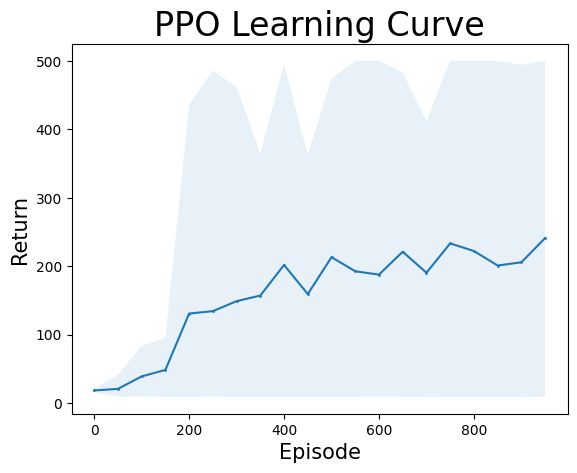

In [ ]:
# Define parameter values
env_name = 'CartPole-v1'
num_train_ite = 1000
num_seeds = 5 # fit model with 5 different seeds and plot average performance of 5 seeds
num_epochs = 10 # how many times we iterate the entire training dataset passing through the training
eval_freq = 50 # run evaluation of policy at each eval_freq trials
eval_epi_index = num_train_ite//eval_freq # use to create x label for plot
returns = np.zeros((num_seeds, eval_epi_index))
gamma = 0.99 # discount factor
clip_val = 0.2 # hyperparameter epsilon in clip objective

# Create the environment.
env = gym.make(env_name)
nA = env.action_space.n
nS = 4

policy_lr = 5e-4 # policy network's learning rate
baseline_lr = 1e-4

for i in tqdm.tqdm(range(num_seeds)):
    reward_means = []

    # Define policy and value networks
    policy_net = NeuralNet(nS, nA, torch.nn.Softmax())
    policy_net_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)
    value_net = NeuralNet(nS, 1, torch.nn.ReLU())
    value_net_optimizer = optim.Adam(value_net.parameters(), lr=baseline_lr)

    for m in range(num_train_ite):
        # Train networks with PPO
        policy_net, value_net = train_PPO(env, policy_net, policy_net_optimizer, value_net, value_net_optimizer, num_epochs, clip_val=clip_val, gamma=gamma)
        if m % eval_freq == 0:
            print("Episode: {}".format(m))
            G = np.zeros(20)
            for k in range(20):
                g = evaluate_policy(env, policy_net)
                G[k] = g

            reward_mean = G.mean()
            reward_sd = G.std()
            print("The avg. test reward for episode {0} is {1} with std of {2}.".format(m, reward_mean, reward_sd))
            reward_means.append(reward_mean)
    returns[i] = np.array(reward_means)

# Plot the performance over iterations
x = np.arange(eval_epi_index)*eval_freq
avg_returns = np.mean(returns, axis=0)
max_returns = np.max(returns, axis=0)
min_returns = np.min(returns, axis=0)

plt.fill_between(x, min_returns, max_returns, alpha=0.1)
plt.plot(x, avg_returns, '-o', markersize=1)

plt.xlabel('Episode', fontsize = 15)
plt.ylabel('Return', fontsize = 15)

plt.title("PPO Learning Curve", fontsize = 24)

